# Numpy实现浅层神经网络


实践部分将搭建神经网络，包含一个隐藏层，实验将会展现出与Logistic回归的不同之处。

实验将使用两层神经网络实现对“花”型图案的分类，如图所示，图中的点包含红点（y=0）和蓝点（y=1）还有点的坐标信息，实验将通过以下步骤完成对两种点的分类，使用Numpy实现。

- 输入样本；

- 搭建神经网络；

- 初始化参数；

- 训练，包括前向传播与后向传播（即BP算法）；

- 得出训练后的参数；

- 根据训练所得参数，绘制两类点边界曲线。

<img src="image/data.png" style="width:400px;height:300px;">

该实验将使用Python原生库实现两层神经网络的搭建，完成分类。


## 1 - 引用库

首先，载入几个需要用到的库，它们分别是：
- numpy：一个python的基本库，用于科学计算
- planar_utils：定义了一些工具函数
- matplotlib.pyplot：用于生成图，在验证模型准确率和展示成本变化趋势时会使用到
- sklearn：用于数据挖掘和数据分析

In [2]:
import numpy as np
import sklearn
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1) 

## 2 - 载入数据并观察纬度

载入数据后，输出维度

In [3]:
#载入数据
train_x, train_y, test_x, test_y = load_planar_dataset()
#输出维度
shape_X = train_x.shape
shape_Y = train_y.shape
print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))


The shape of X is: (2, 320)
The shape of Y is: (1, 320)


由输出可知每组输入坐标包含两个值，包含一个值，共320组数据（测试集在训练集基础上增加80组数据，共400组）。

## 3 - 简单逻辑回归实验

使用逻辑回归处理该数据，观察分类结果

/Users/starwe/Desktop/WorkDir/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of logistic regression:57 % (percentage of correctly labelled datapoints)


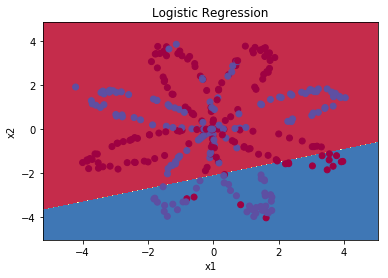

In [4]:
#训练逻辑回归分类器
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(train_x.T, train_y.T);
#绘制逻辑回归分类边界
plot_decision_boundary(lambda x: clf.predict(x), train_x, train_y)
plt.title("Logistic Regression")

#输出准确率
LR_predictions = clf.predict(train_x.T)
print ('Accuracy of logistic regression:%d ' % float((np.dot(train_y,LR_predictions) + np.dot(1-train_y,1-LR_predictions))/float(train_y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")


可以看出逻辑回归效果并不好，这是因为逻辑回归网络结构只包含输入层和输出层，无法拟合更为复杂的模型，下面尝试神经网络模型。


## 4 - 神经网络模型

下面开始搭建神经网络模型，我们采用两层神经网络实验，隐藏层包含4个节点，使用tanh激活函数；输出层包含一个节点，使用Sigmoid激活函数，结果小于0.5即认为是0，否则认为是1。

** 神经网络结构 **

下面用代码实现神经网络结构，首先确定神经网络的结构，即获取相关数据维度，并设置隐藏层节点个数（本实验设置4个隐藏层节点），用以初始化参数

In [6]:
#定义各层规模函数
def layer_sizes(X, Y):
    """
    参数含义:
    X -- 输入的数据
    Y -- 输出值
    
    返回值:
    n_x -- 输入层节点数
    n_h -- 隐藏层节点数
    n_y -- 输出层节点数
    """
    
    n_x = X.shape[0] #输入层大小（节点数）
    n_h = 4
    n_y = Y.shape[0] #输出层大小（节点数）
    return (n_x, n_h, n_y)

** 初始化模型参数 **

获取相关维度信息后，开始初始化参数，定义相关函数

In [7]:
# 定义函数：初始化参数

def initialize_parameters(n_x, n_h, n_y):
    """
    参数:
    n_x -- 输入层大小
    n_h -- 隐藏层大小
    n_y -- 输出层大小
    
    返回值:
    params -- 一个包含所有参数的python字典:
                    W1 -- （隐藏层）权重，维度是 (n_h, n_x)
                    b1 -- （隐藏层）偏移量，维度是 (n_h, 1)
                    W2 -- （输出层）权重，维度是 (n_y, n_h)
                    b2 -- （输出层）偏移量，维度是 (n_y, 1)
    """
    
    np.random.seed(2) # 设置随机种子
    
    #随机初始化参数
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters


** 前向传播与后向传播 **

获取输入数据，参数初始化完成后，可以开始前向传播的计算

In [8]:
# 定义函数：前向传播

def forward_propagation(X, parameters):
    """
    参数:
    X -- 输入值 
    parameters -- 一个python字典，包含计算所需全部参数（是initialize_parameters函数的输出）    
    返回值:
    A2 -- 模型输出值
    cache -- 一个字典，包含 "Z1", "A1", "Z2" and "A2"
    """
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    #计算中间量和节点值    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = 1/(1+np.exp(-Z2))
    
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

前向传播最后可得出模型输出值（即代码中的A2），即可计算成本函数cost

In [9]:
# 定义函数：成本函数

def compute_cost(A2, Y, parameters):
    """
   根据第三章给出的公式计算成本
    
    参数:
A2 -- 模型输出值    
Y -- 真实值
    parameters -- 一个python字典包含参数 W1, b1, W2和b2
    
    返回值:
    cost -- 成本函数
    """
    
    m = Y.shape[1] #样本个数

    #计算成本
    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1 - A2), 1 - Y)
    cost =  -1. / m * np.sum(logprobs)
    
    cost = np.squeeze(cost)     # 确保维度的正确性                        
    assert(isinstance(cost, float))
    
    return cost

计算了成本函数，可以开始后向传播的计算

In [10]:
# 定义函数：后向传播

def backward_propagation(parameters, cache, X, Y):
    """    
    参数:
    parameters -- 一个python字典，包含所有参数 
    cache -- 一个python字典包含"Z1", "A1", "Z2"和"A2".
    X -- 输入值
    Y -- 真实值
    
    返回值:
    grads -- 一个python字典包含所有参数的梯度
    """
    m = X.shape[1]
  
    #首先从"parameters"获取W1,W2
    W1 = parameters["W1"]
    W2 = parameters["W2"]
        
    # 从"cache"中获取A1,A2
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    #后向传播: 计算dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = 1. / m * np.dot(dZ2, A1.T)
    db2 = 1. / m * np.sum(dZ2, axis = 1, keepdims = True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = 1. / m * np.dot(dZ1, X.T)
    db1 = 1. / m * np.sum(dZ1, axis = 1, keepdims = True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

通过后向传播获取梯度后，可以根据梯度下降公式更新参数

In [11]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    使用梯度更新参数
    
    参数:
    parameters -- 包含所有参数的python字典 
    grads -- 包含所有参数梯度的python字典 
    
    返回值:
    parameters -- 包含更新后参数的python 
    """
    #从"parameters"中读取全部参数
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # 从"grads"中读取全部梯度
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    #更新参数
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

** 神经网络模型 **

前向传播、成本函数计算和后向传播构成一个完整的神经网络，将上述函数组合，构建一个神经网络模型

In [12]:
#定义函数：神经网络模型
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    参数:
    X -- 输入值
    Y -- 真实值
    n_h -- 隐藏层大小/节点数
    num_iterations -- 训练次数
    print_cost -- 设置为True，则每1000次训练打印一次成本函数值
    
    返回值:
parameters -- 训练结束，更新后的参数值    
"""
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    #根据n_x, n_h, n_y初始化参数，并取出W1,b1,W2,b2   
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    
    for i in range(0, num_iterations):      
       
        #前向传播， 输入: "X, parameters". 输出: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        #成本计算. 输入: "A2, Y, parameters". 输出: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        #后向传播， 输入: "parameters, cache, X, Y". 输出: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        #参数更新. 输入: "parameters, grads". 输出: "parameters".
        parameters = update_parameters(parameters, grads)
        
        #每1000次训练打印一次成本函数值
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters


** 预测 ** 

通过上述模型可以训练得出最后的参数，此时需检测其准确率，用训练后的参数预测训练的输出，大于0.5的值视作1，否则视作0

In [13]:
#定义函数：预测
def predict(parameters, X):
    """
    使用训练所得参数，对每个训练样本进行预测
    
    参数:
    parameters -- 保安所有参数的python字典 
    X -- 输入值
    
    返回值：
    predictions -- 模型预测值向量(红色: 0 / 蓝色: 1)
    """
    
    #使用训练所得参数进行前向传播计算，并将模型输出值转化为预测值（大于0.5视作1，即True）
    A2, cache = forward_propagation(X, parameters)
    predictions = A2 > 0.5

    return predictions

下面对获取的数据进行训练，并输出准确率

Cost after iteration 0: 0.693049
Cost after iteration 1000: 0.272304
Cost after iteration 2000: 0.261430
Cost after iteration 3000: 0.260627
Cost after iteration 4000: 0.257842
Cost after iteration 5000: 0.255809
Cost after iteration 6000: 0.254249
Cost after iteration 7000: 0.253019
Cost after iteration 8000: 0.252028
Cost after iteration 9000: 0.251208
Train Accuracy: 90%
Test Accuracy: 89%


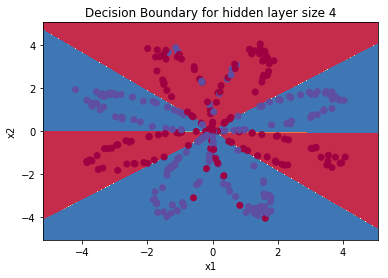

In [17]:
#建立神经网络模型
parameters = nn_model(train_x, train_y, n_h = 4, num_iterations = 10000, print_cost=True)

#绘制分类边界
plot_decision_boundary(lambda x: predict(parameters, x.T), train_x, train_y)
plt.title("Decision Boundary for hidden layer size " + str(4))
 
predictions = predict(parameters, train_x)
# 预测训练集
print('Train Accuracy: %d' % float((np.dot(train_y, predictions.T) +
                                    np.dot(1 - train_y, 1 - predictions.T)) /
                                    float(train_y.size) * 100) + '%')
# 预测测试集
predictions = predict(parameters, test_x)
print('Test Accuracy: %d' % float((np.dot(test_y, predictions.T) +
                                    np.dot(1 - test_y, 1 - predictions.T)) /
                                    float(test_y.size) * 100) + '%')

对比逻辑回归47%的准确率和分类结果图，神经网络分类的结果提高了不少，这是因为神经网络增加的隐藏层，为模型训练提供了更多选择，使得神经网络能拟合更加复杂的模型，对于更加复杂的图案分类更加准确。
